In [19]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from PIL import Image
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import cv2

In [20]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=None)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(num_classes=2)
model.load_state_dict(torch.load("best_model.pth", map_location=device, weights_only=True))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [22]:
image_dir = "./dataset/test/img"
transform = T.Compose([T.ToTensor()])


--- 20250510_184610_jpg.rf.c0a2499b611feb68c8719bde2afdcf5e.jpg ---


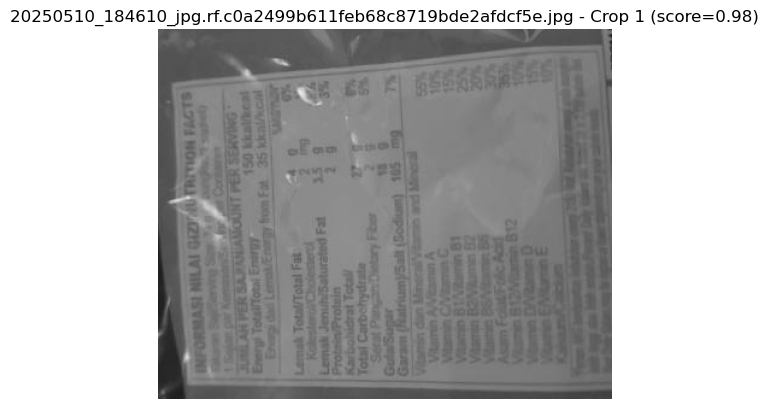


--- 20250510_185639_jpg.rf.a0fde935430365a41ca720510eab231e.jpg ---


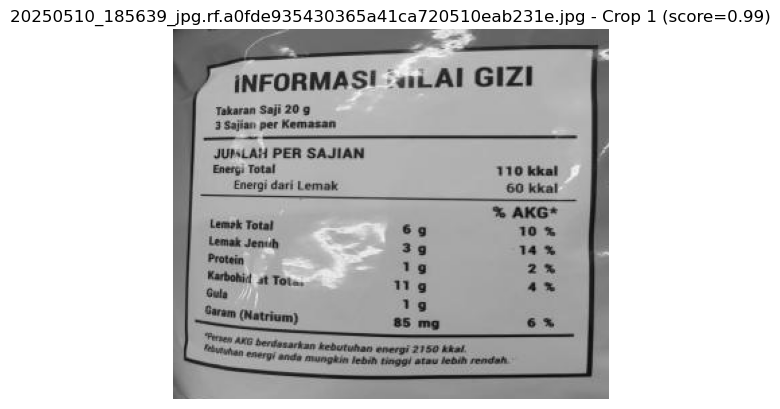


--- 20250510_185728_jpg.rf.41d1eebd9fb0cbe3ed43a47d804746ce.jpg ---


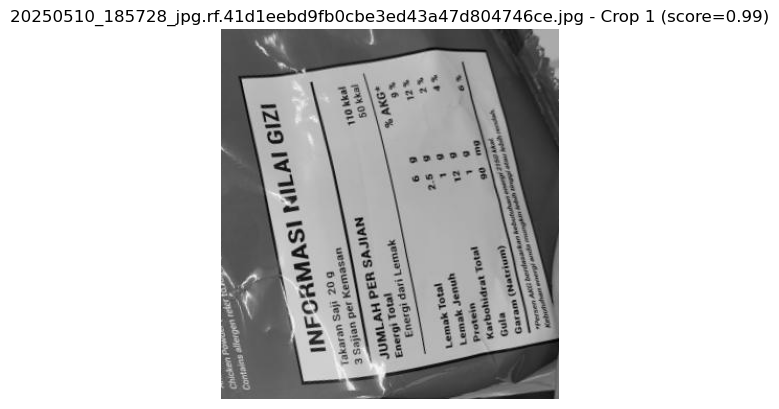


--- 20250510_185818_jpg.rf.17ab01eff515e93cc0551cb1783276c4.jpg ---


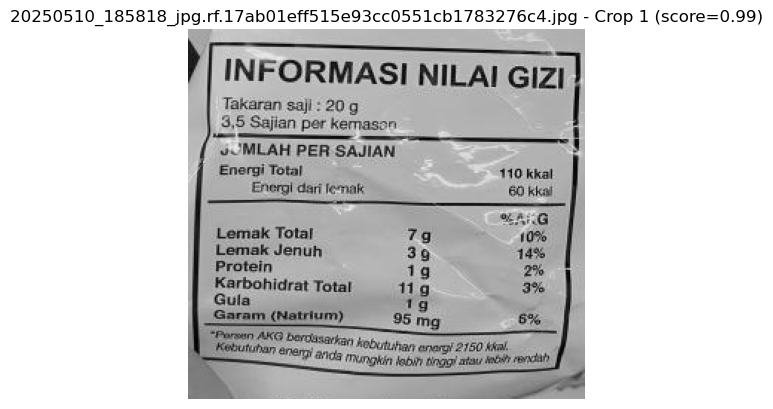


--- 20250510_190139_jpg.rf.a52e0a850553ff1dd42d5fe8265acbf0.jpg ---


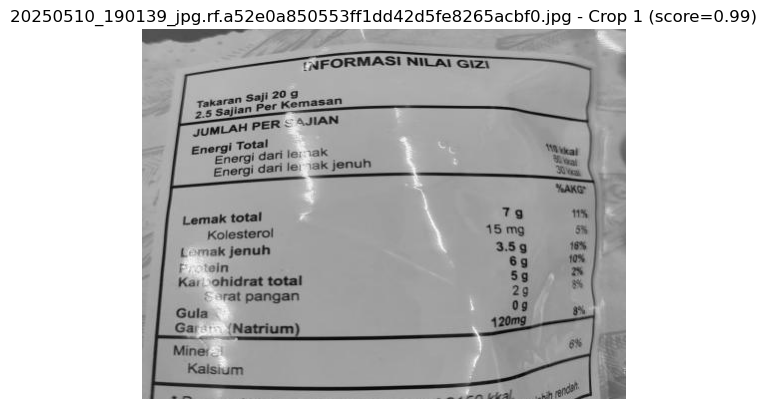


--- 20250510_190151_jpg.rf.25820a1162fe68d4375acfe771ca0d76.jpg ---


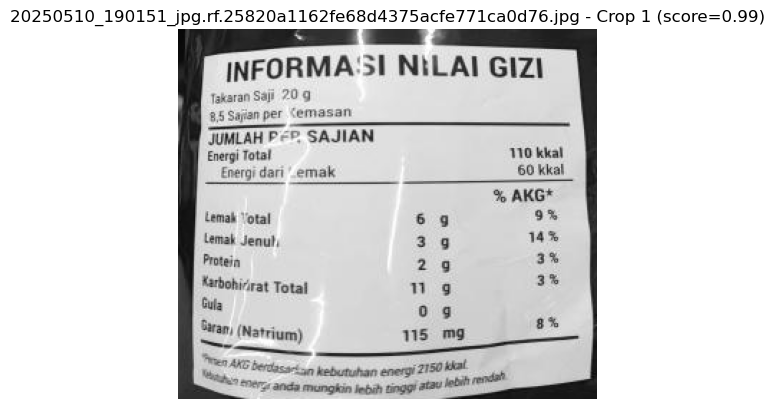


--- 20250510_190215_jpg.rf.31e84d63e2004e290f6089b652aade3f.jpg ---


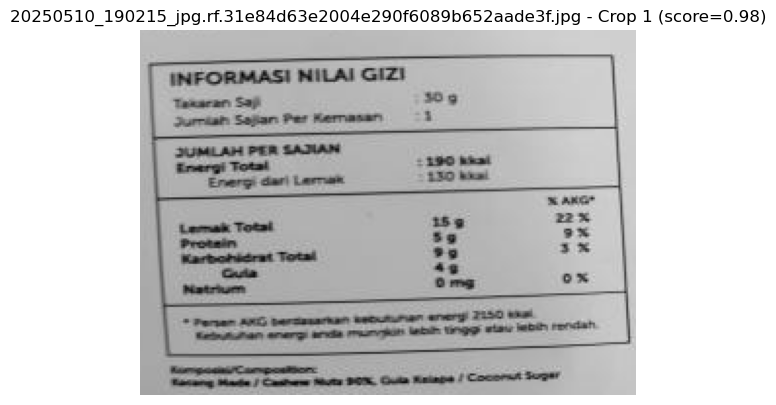


--- 20250510_190422_jpg.rf.ecc4b174b6f988ee468ab4e7e7a8c24a.jpg ---


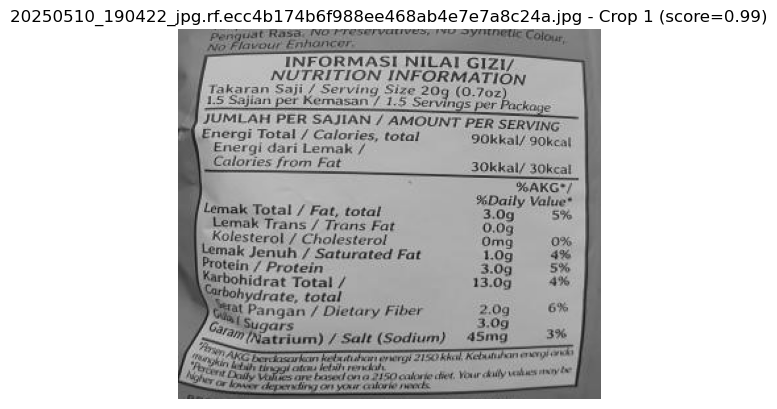


--- 20250510_190612_jpg.rf.724424b2233226d54a6d03c653816e61.jpg ---


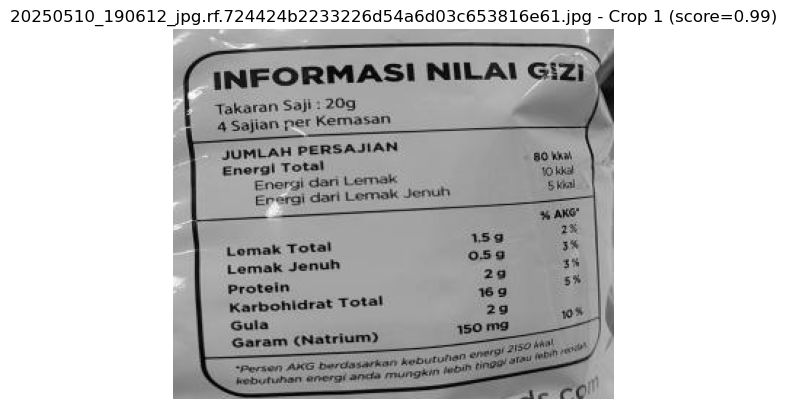


--- 20250510_190950_jpg.rf.81c29275002d666f1bbd743ede141ebf.jpg ---


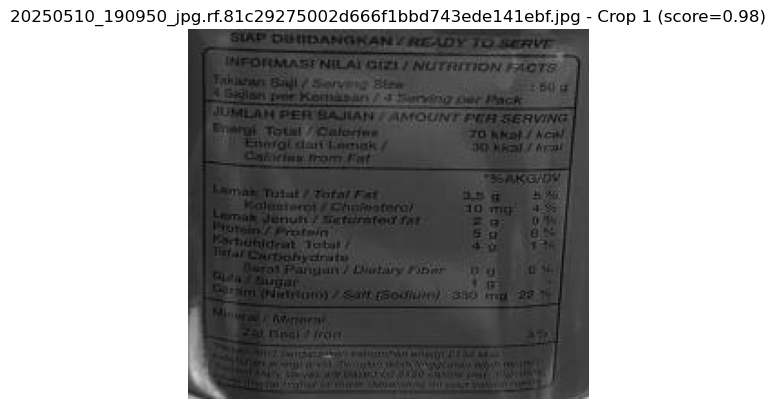


--- image.png ---


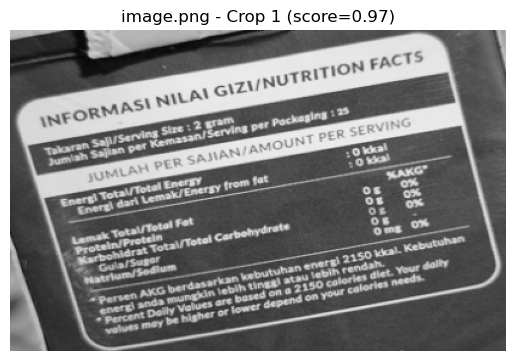

In [23]:
for filename in os.listdir(image_dir):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (640, 640))

    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    pil_image = Image.fromarray(resized_image_rgb)

    transform = T.ToTensor()
    img_tensor = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    boxes = prediction["boxes"]
    scores = prediction["scores"]

    print(f"\n--- {filename} ---")

    for i, (box, score) in enumerate(zip(boxes, scores)):
        if score < 0.5:
            continue
        box = box.int().cpu().numpy()
        xmin, ymin, xmax, ymax = box

        cropped = resized_image[ymin:ymax, xmin:xmax]

        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB))
        plt.title(f"{filename} - Crop {i+1} (score={score:.2f})")
        plt.axis("off")
        plt.show()